<a href="https://colab.research.google.com/github/antbartash/product_failure/blob/main/catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading libraries and data <br>
Since CatBoost supports missing values for numerical features, we don't need to fill them ourselves. CatBoost requires missing values to be filled for categorical features, but the dataset contains missing values only for numerical features. Also decision trees are fine with not-scaled features and KNN is not needed, so StandardScaler won't be applied

In [2]:
# in case of catboost is not installed or the notebook is run on Google Colab
# pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 80 kB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, CatBoost
from sklearn.metrics import roc_auc_score
from scipy.stats import uniform, randint

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
X_train = pd.read_csv('drive/MyDrive/product_failure/data/X_train.csv', index_col=0)
X_test = pd.read_csv('drive/MyDrive/product_failure/data/X_test.csv', index_col=0)
y_train = pd.read_csv('drive/MyDrive/product_failure/data/y_train.csv', index_col=0)
y_test = pd.read_csv('drive/MyDrive/product_failure/data/y_test.csv', index_col=0)

Check first 5 observations and data shapes to make sure that the data was read correctly

In [7]:
X_train.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,measurement_0_grouped,measurement_1_grouped,measurement_2_grouped
1630,A,107.53,material_7,material_8,9,5,16,2,4,NaN,...,18.014,14.962,16.743,14.487,14.351,15.737,705.885,"(13.0, 29.0]","(-0.001, 4.0]","(3.0, 4.0]"
18030,D,128.99,material_7,material_5,6,6,3,9,5,17.242,...,18.873,11.384,15.002,NaN,19.237,NaN,841.809,"(-0.001, 3.0]","(7.0, 9.0]","(4.0, 5.0]"
26078,E,128.33,material_7,material_6,6,9,4,16,5,16.094,...,19.696,10.480,15.294,16.715,15.292,15.861,632.835,"(3.0, 4.0]","(13.0, 29.0]","(4.0, 5.0]"
19823,D,125.21,material_7,material_5,6,6,11,9,6,16.677,...,21.130,13.625,15.095,15.394,12.846,19.156,643.322,"(9.0, 11.0]","(7.0, 9.0]","(5.0, 6.0]"
15788,C,106.12,material_7,material_8,5,8,5,6,6,16.963,...,17.362,10.523,15.199,17.476,NaN,15.472,545.206,"(4.0, 5.0]","(4.0, 6.0]","(5.0, 6.0]"


In [8]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape:  (19927, 27)
y_train.shape:  (19927, 1)
X_test.shape:  (6643, 27)
y_test.shape: (6643, 1)


In [9]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

print("y_train.shape: ", y_train.shape)
print("y_test.shape:", y_test.shape)

y_train.shape:  (19927,)
y_test.shape: (6643,)


# Baseline model <br>
Build a baseline CatBoost model and evaluate its performance on train and test sets. For performance evaluation AUC and logloss will be used

In [10]:
# index of categorical features for a CatBoost model
cat_features_index = [0, 2, 3, 4, 5, 24, 25, 26]

In [ ]:
model_baseline = CatBoostClassifier(iterations=1000, custom_metric='AUC',
                                    random_state=42)
model_baseline.fit(X_train, y_train, cat_features=cat_features_index,
                   early_stopping_rounds=100, eval_set=(X_test, y_test),
                   verbose=100, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.066355
0:	learn: 0.6678232	test: 0.6680307	best: 0.6680307 (0)	total: 295ms	remaining: 4m 54s
100:	learn: 0.4966931	test: 0.5091784	best: 0.5090023 (68)	total: 12.1s	remaining: 1m 47s
200:	learn: 0.4761336	test: 0.5094809	best: 0.5089225 (122)	total: 25s	remaining: 1m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5089224834
bestIteration = 122

Shrink model to first 123 iterations.


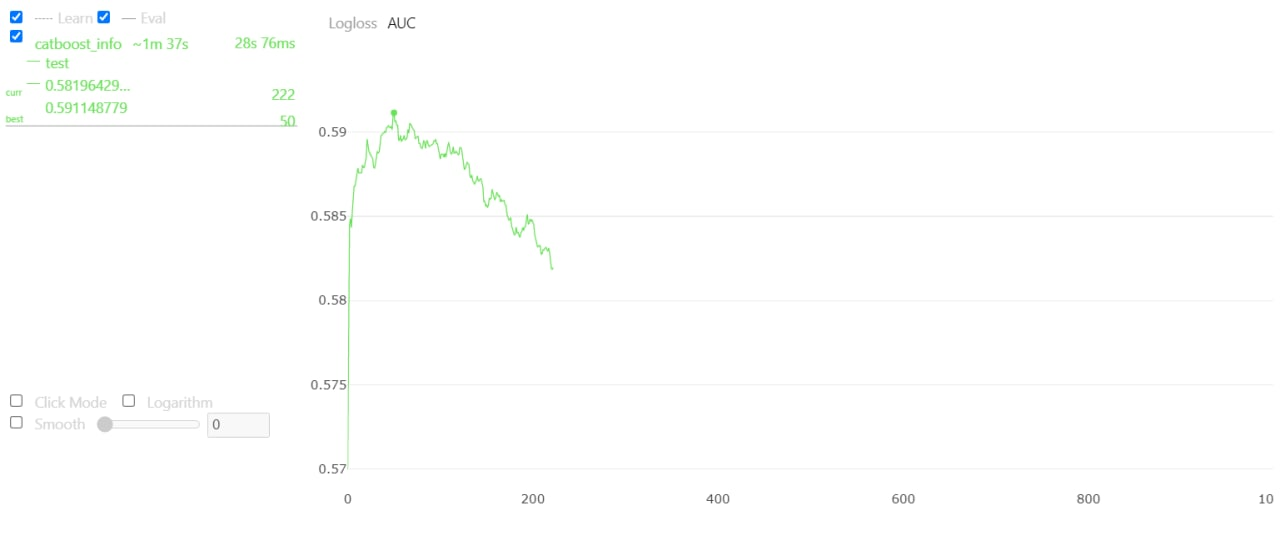

Based on the result above, we can conclude that for the default values of model parameters, AUC achives the maximum for the test set at the 50th iteration, and starts to fall after that. To tune parameters values catboost randomized_search() method will be used

# Tuning parameters values <br>

Round 1

In [ ]:
model = CatBoostClassifier(cat_features=cat_features_index,
                           eval_metric='AUC:hints=skip_train~false',
                           custom_metric='AUC:hints=skip_train~false', 
                           early_stopping_rounds=250,
                           random_state=42,
                           verbose=False)

In [ ]:
distr = {
    'learning_rate': uniform(0.01, 0.2),
    'iterations': randint(50, 1000),
    'depth': [1, 4, 6, 10],
    'l2_leaf_reg': [0, 5, 10, 15],
    'random_strength': [0, 3, 7, 10],
    'bagging_temperature': [0, 1, 3, 5]
}

search_results = model.randomized_search(distr, X_train, y_train,
                                         cv=5, n_iter=200,
                                         verbose=False, plot=False)

In [ ]:
search_results['params']

{'bagging_temperature': 0,
 'random_strength': 3,
 'depth': 6,
 'l2_leaf_reg': 5,
 'learning_rate': 0.18330239291193462,
 'iterations': 773.0}

In [12]:
model1_grid = CatBoostClassifier(cat_features=cat_features_index,
                                eval_metric='AUC:hints=skip_train~false',
                                custom_metric='AUC:hints=skip_train~false', 
                                early_stopping_rounds=250,
                                random_state=42,
                                verbose=False)
grid = {
    'iterations': [750],
    'depth': [10, 8, 7, 6, 5],
    'l2_leaf_reg': [3, 4, 5, 6, 7],
    'random_strength': [2, 3, 4, 5],
    'bagging_temperature': [0, 0.5]
}

grid1_results = model1_grid.grid_search(grid, X_train, y_train,
                                        cv=5,
                                        verbose=20, plot=False)

Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.5810260233
bestIteration = 151

0:	loss: 0.5810260	best: 0.5810260 (0)	total: 45.2s	remaining: 2h 29m 55s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.5816037503
bestIteration = 121

Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.5787815997
bestIteration = 107

Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.5842042861
bestIteration = 67

Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.5832616588
bestIteration = 91

Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.578988695
bestIteration = 155

Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.5826101875
bestIteration = 86

Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.5780923011
bestIteration = 60

Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.5833747588
bestIteration = 206

Stopped by overfitting

In [13]:
grid1_results['params']

{'bagging_temperature': 0,
 'random_strength': 3,
 'depth': 6,
 'l2_leaf_reg': 7,
 'iterations': 750}

In [16]:
model2_grid = CatBoostClassifier(cat_features=cat_features_index,
                                eval_metric='AUC:hints=skip_train~false',
                                custom_metric='AUC:hints=skip_train~false', 
                                early_stopping_rounds=250,
                                random_state=42,
                                verbose=False)
grid = {
    'iterations': [750],
    'depth': [6],
    'l2_leaf_reg': [6, 7, 8, 9, 10, 15],
    'random_strength': [2, 3, 4],
    'bagging_temperature': [0]
}

grid2_results = model2_grid.grid_search(grid, X_train, y_train,
                                        cv=5,
                                        verbose=1, plot=False)

Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.5830900983
bestIteration = 345

0:	loss: 0.5830901	best: 0.5830901 (0)	total: 24.2s	remaining: 6m 52s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.5810187635
bestIteration = 152

1:	loss: 0.5810188	best: 0.5830901 (0)	total: 39.5s	remaining: 5m 16s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.5821432679
bestIteration = 72

2:	loss: 0.5821433	best: 0.5830901 (0)	total: 50.9s	remaining: 4m 14s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.5834588196
bestIteration = 42

3:	loss: 0.5834588	best: 0.5834588 (3)	total: 1m 2s	remaining: 3m 38s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.5858996398
bestIteration = 40

4:	loss: 0.5858996	best: 0.5858996 (4)	total: 1m 12s	remaining: 3m 8s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.5839612739
bestIteration = 95

5:	loss: 0.5839613	best: 0.5858996 (4)	total: 1m

In [17]:
grid2_results['params']

{'bagging_temperature': 0,
 'random_strength': 3,
 'depth': 6,
 'l2_leaf_reg': 7,
 'iterations': 750}

In [18]:
model3_grid = CatBoostClassifier(cat_features=cat_features_index,
                                 depth=6, l2_leaf_reg=7,
                                 random_strength=3, bagging_temperature=0,
                                 eval_metric='AUC:hints=skip_train~false',
                                 custom_metric='AUC:hints=skip_train~false',
                                 random_state=42,
                                 verbose=False)
grid = {
    'iterations': [5000, 4000, 3000, 2000, 1000, 750, 500, 250, 100]
}

grid3_results = model3_grid.grid_search(grid, X_train, y_train,
                                        cv=5,
                                        verbose=1, plot=False)


bestTest = 0.5885013219
bestIteration = 23

0:	loss: 0.5885013	best: 0.5885013 (0)	total: 3m 59s	remaining: 31m 55s

bestTest = 0.5885013219
bestIteration = 23

1:	loss: 0.5885013	best: 0.5885013 (0)	total: 7m 8s	remaining: 24m 59s

bestTest = 0.5885013219
bestIteration = 23

2:	loss: 0.5885013	best: 0.5885013 (0)	total: 9m 28s	remaining: 18m 56s

bestTest = 0.5885013219
bestIteration = 23

3:	loss: 0.5885013	best: 0.5885013 (0)	total: 11m	remaining: 13m 45s

bestTest = 0.5885013219
bestIteration = 23

4:	loss: 0.5885013	best: 0.5885013 (0)	total: 11m 43s	remaining: 9m 22s

bestTest = 0.5885013219
bestIteration = 23

5:	loss: 0.5885013	best: 0.5885013 (0)	total: 12m 14s	remaining: 6m 7s

bestTest = 0.5885013219
bestIteration = 23

6:	loss: 0.5885013	best: 0.5885013 (0)	total: 12m 35s	remaining: 3m 35s

bestTest = 0.5885013219
bestIteration = 23

7:	loss: 0.5885013	best: 0.5885013 (0)	total: 12m 44s	remaining: 1m 35s

bestTest = 0.5809144517
bestIteration = 98

8:	loss: 0.5809145	best:

In [19]:
grid3_results['params']

{'iterations': 5000}

In [20]:
grid3_results['cv_results']

defaultdict(list,
            {'iterations': [0,
              1,
              2,
              3,
              4,
              5,
              6,
              7,
              8,
              9,
              10,
              11,
              12,
              13,
              14,
              15,
              16,
              17,
              18,
              19,
              20,
              21,
              22,
              23,
              24,
              25,
              26,
              27,
              28,
              29,
              30,
              31,
              32,
              33,
              34,
              35,
              36,
              37,
              38,
              39,
              40,
              41,
              42,
              43,
              44,
              45,
              46,
              47,
              48,
              49,
              50,
              51,
              52,
              53,
      